<h1 style="text-align:center;">SpaceX  Falcon 9 First Stage Landing Prediction</h1>



SpaceX advertises Falcon 9 rocket launches on its website with a cost of 62 million dollars, other providers cost upward of 165 million dollars each, much of the savings is because SpaceX can reuse the first stage. Therefore if we can determine if the first stage will land, we can determine the cost of a launch. This information can be used if an alternate company wants to bid against spaceX for a rocket launch. In this notebook, we will create a machine learning pipeline to predict if the first stage will land given the data from the preceding labs.

![Landing](https://raw.githubusercontent.com/Dahamey/Dahamey.github.io/main/landing.gif)


Several examples of an unsuccessful landing are shown here:



Most unsuccessful landings are planed. SpaceX, performs a controlled landing in the oceans.


# Objectives 

Perform Exploratory Data Analysis (EDA) and determine Training Labels

* Create a column for the class

* Standardize the data

* Split into training data and test data

* Find best Hyperparameter for SVM, Classification Trees and Logistic Regression

* Find the method performs best using test data

# 1) Import Libraries and Define Auxiliary Functions

We will import the following libraries for the lab

In [1]:
# Pandas is a software library written for the Python programming language for data manipulation and analysis.
import pandas as pd

# NumPy is a library for the Python programming language, adding support for large, multi-dimensional arrays and matrices, along with a large collection of high-level mathematical functions to operate on these arrays
import numpy as np

# Matplotlib is a plotting library for python and pyplot gives us a MatLab like plotting framework. We will use this in our plotter function to plot data.
import matplotlib.pyplot as plt

#Seaborn is a Python data visualization library based on matplotlib. It provides a high-level interface for drawing attractive and informative statistical graphics
import seaborn as sns

# Preprocessing allows us to standarsize our data
from sklearn import preprocessing

# Allows us to split our data into training and testing data
from sklearn.model_selection import train_test_split

# Allows us to test parameters of classification algorithms and find the best one
from sklearn.model_selection import GridSearchCV

# Logistic Regression classification algorithm
from sklearn.linear_model import LogisticRegression

# Support Vector Machine classification algorithm
from sklearn.svm import SVC

# Decision Tree classification algorithm
from sklearn.tree import DecisionTreeClassifier

# K Nearest Neighbors classification algorithm
from sklearn.neighbors import KNeighborsClassifier

import warnings
warnings.filterwarnings('ignore')

The help function will plot the confusion matrix

In [2]:
def plot_confusion_matrix(y_true, y_pred) :
    """This function plots the confusion matrix"""
    
    from sklearn.metrics import confusion_matrix
    cm = confusion_matrix(y_true, y_pred)
    ax = plt.subplot()
    sns.heatmap(cm, annot= True, ax = ax);
    ax.set_xlabel("Predicted labels")
    ax.set_ylabel("True labels")
    ax.set_title("Confusion Matrix");
    ax.xaxis.set_ticklabels(["did not land", "land"]); ax.yaxis.set_ticklabels(['did not land', 'landed'])

# 2) Load the dataframe

Load the data

In [3]:
df_raw = pd.read_csv("https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/datasets/dataset_part_2.csv")
df = df_raw.copy()

df.head()

,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude,Class
0,1,2010-06-04,Falcon 9,6104.959412,LEO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0003,-80.577366,28.561857,0
1,2,2012-05-22,Falcon 9,525.000000,LEO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0005,-80.577366,28.561857,0
2,3,2013-03-01,Falcon 9,677.000000,ISS,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0007,-80.577366,28.561857,0
3,4,2013-09-29,Falcon 9,500.000000,PO,VAFB SLC 4E,False Ocean,1,False,False,False,NaN,1.0,0,B1003,-120.610829,34.632093,0
4,5,2013-12-03,Falcon 9,3170.000000,GTO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B1004,-80.577366,28.561857,0


In [4]:
df.shape

(90, 18)

In [5]:
df.columns

Index(['FlightNumber', 'Date', 'BoosterVersion', 'PayloadMass', 'Orbit',
       'LaunchSite', 'Outcome', 'Flights', 'GridFins', 'Reused', 'Legs',
       'LandingPad', 'Block', 'ReusedCount', 'Serial', 'Longitude', 'Latitude',
       'Class'],
      dtype='object')

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90 entries, 0 to 89
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   FlightNumber    90 non-null     int64  
 1   Date            90 non-null     object 
 2   BoosterVersion  90 non-null     object 
 3   PayloadMass     90 non-null     float64
 4   Orbit           90 non-null     object 
 5   LaunchSite      90 non-null     object 
 6   Outcome         90 non-null     object 
 7   Flights         90 non-null     int64  
 8   GridFins        90 non-null     bool   
 9   Reused          90 non-null     bool   
 10  Legs            90 non-null     bool   
 11  LandingPad      64 non-null     object 
 12  Block           90 non-null     float64
 13  ReusedCount     90 non-null     int64  
 14  Serial          90 non-null     object 
 15  Longitude       90 non-null     float64
 16  Latitude        90 non-null     float64
 17  Class           90 non-null     int64

In [7]:
X = pd.read_csv('https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/datasets/dataset_part_3.csv')
X.head()

,FlightNumber,PayloadMass,Flights,Block,ReusedCount,Orbit_ES-L1,Orbit_GEO,Orbit_GTO,Orbit_HEO,Orbit_ISS,...,Serial_B1058,Serial_B1059,Serial_B1060,Serial_B1062,GridFins_False,GridFins_True,Reused_False,Reused_True,Legs_False,Legs_True
0,1.0,6104.959412,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
1,2.0,525.000000,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
2,3.0,677.000000,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
3,4.0,500.000000,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
4,5.0,3170.000000,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0


In [8]:
X.shape

(90, 83)

# 3) Splitting the data

We're going to create a Numpy array from the column `Class` in `df`, by applying the method `to_numpy()` then assign the variable `y`, we make sure the output is a Pandas series (only one bracket df['name of column']).

In [9]:
df["Class"].unique()

array([0, 1], dtype=int64)

In [10]:
# Target variable as numpy array
y = df["Class"].to_numpy()
y

array([0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1,
       1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1], dtype=int64)

In [11]:
y.dtype

dtype('int64')

# 4) Standardization

We standardize the data in `X` then reassign it to the variable `X` using the transform provided below

In [12]:
# Normalizing the features
scaler = preprocessing.StandardScaler()
X = scaler.fit_transform(X)

# 5) Splitting the data into training/testing

We split the data into training and testing data using the function `train_test_split`. The training data is divided into validation data, a second set used for training data; then the models are trained and hyperparameters are selected using the function `GridSearchCV`.

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=25)

We can see that we only have 18 test samples :

In [14]:
print ('Train set:')
print('X-train= ', X_train.shape,'Y-train= ',y_train.shape)
print ('Test set:')
print('X-test= ', X_test.shape,  'Y-test= ',y_test.shape)

Train set:
X-train=  (72, 83) Y-train=  (72,)
Test set:
X-test=  (18, 83) Y-test=  (18,)


# 6) Modeling & Cross-Validated hyperparameter tuning

## 6-1) Logistic Regression : Fitting the model

In [15]:
%%time

# Defining the model used
lr = LogisticRegression(random_state=25)

# Defining the dictionary of hyperparameters to tune
cv_params_lr = {"C": [0.01, 0.1, 1],
               "penalty" : ["l2"],
               "solver" : ["lbfgs"]} # L1 lasso L2 ridge

# Scoring dictionary
scoring = {"accuracy", "precision", "recall", "f1"}

# Defining the grid search object
lr_cv = GridSearchCV(estimator=lr,
                    param_grid= cv_params_lr,
                    scoring=scoring,
                    cv = 10,
                    refit="accuracy")

# Execute search
lr_cv.fit(X_train, y_train)

CPU times: total: 391 ms
Wall time: 407 ms


GridSearchCV(cv=10, estimator=LogisticRegression(random_state=25),
             param_grid={'C': [0.01, 0.1, 1], 'penalty': ['l2'],
                         'solver': ['lbfgs']},
             refit='accuracy',
             scoring={'f1', 'accuracy', 'precision', 'recall'})

We output the `GridSearchCV` object for logistic regression. We display the best parameters using the data attribute `best_params_` and the accuracy on the validation data using the data attribute `best_score_`.

In [16]:
print("Tuned hyperparameters : (best parameters) :\n", lr_cv.best_params_)
print("The accuracy associated with the best set of hyperparameters : ", lr_cv.best_score_)

Tuned hyperparameters : (best parameters) :
 {'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs'}
The accuracy associated with the best set of hyperparameters :  0.8232142857142858


## 6-2) Logistic Regression :  Evaluating the model

Let's evaluate the model by calculating the accuracy on the test data using the `score` method.

In [17]:
print("Accuracy on test data is : {:.3f}".format(lr_cv.score(X_test, y_test)))

Accuracy on test data is : 0.833


We can see that the Logistic model is performing very well on unseen data.

## 6-3) Logistic Regression :  Confusion Matrix

Let's look at the confusion matrix

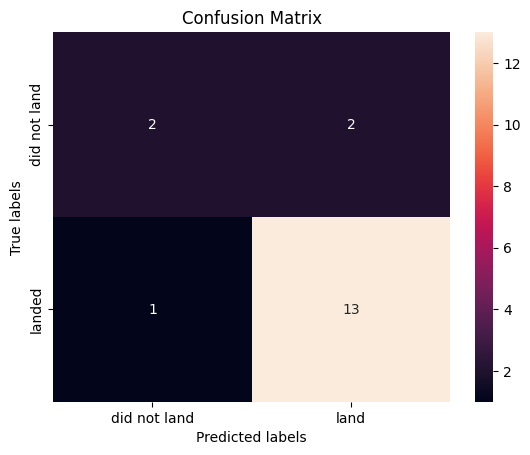

In [18]:
# Predictions : (y hat)
y_pred_lr = lr_cv.predict(X_test)

# Creating the confusion matrix 
plot_confusion_matrix(y_test, y_pred_lr)

Examining the confusion matrix, we see :

* **Advantage :**  logistic regression can distinguish between the different classes.

* **Disavantage :** We see that the problem is false positives (where our classifier predicted the rocket would land, but they didn't)

## 6-4) Support Vector Machine : Fitting the model

Let's create a SVM object, and a `GridSearchCV` object, `svm_cv` with cv - 10, and fit the object to find the best parameters from the dictionary `cv_params_svm`. 

In [19]:
%%time

# Defining the model used
svm = SVC(random_state=25)

# Defining the dictionary of hyperparameters to tune
cv_params_svm = {"kernel" : ('linear', 'rbf','poly','rbf', 'sigmoid'),
              "C" : np.logspace(-3, 3, 5),
              "gamma" : np.logspace(-3, 3, 5)}

# Scoring dictionary
scoring = {"accuracy", "precision", "recall", "f1"}

# Defining the grid search object
svm_cv = GridSearchCV(estimator=svm,
                    param_grid= cv_params_svm,
                    scoring=scoring,
                    cv = 10,
                    refit="accuracy")

# Execute search
svm_cv.fit(X_train, y_train)

CPU times: total: 10.1 s
Wall time: 11.5 s


GridSearchCV(cv=10, estimator=SVC(random_state=25),
             param_grid={'C': array([1.00000000e-03, 3.16227766e-02, 1.00000000e+00, 3.16227766e+01,
       1.00000000e+03]),
                         'gamma': array([1.00000000e-03, 3.16227766e-02, 1.00000000e+00, 3.16227766e+01,
       1.00000000e+03]),
                         'kernel': ('linear', 'rbf', 'poly', 'rbf', 'sigmoid')},
             refit='accuracy',
             scoring={'f1', 'accuracy', 'precision', 'recall'})

In [20]:
print("Tuned hyperparameters : (best parameters) :\n", svm_cv.best_params_)
print("The accuracy associated with the best set of hyperparameters : ", svm_cv.best_score_)

Tuned hyperparameters : (best parameters) :
 {'C': 1.0, 'gamma': 0.03162277660168379, 'kernel': 'sigmoid'}
The accuracy associated with the best set of hyperparameters :  0.8357142857142857


## 6-5) Support Vector Machine :  Evaluating the model

Let's evaluate the model by calculating the accuracy on the test data using the `score` method.

In [21]:
print("The accuracy test data is : {:.3f}".format(svm_cv.score(X_test,y_test)))

The accuracy test data is : 0.889


## 6-6) Support Vector Machine :  Confusion Matrix

Let's look at the confusion matrix

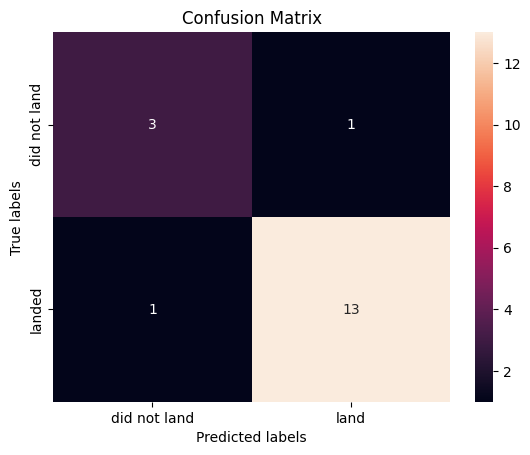

In [22]:
# Predictions : 
y_pred_svm = svm_cv.predict(X_test)

# Creating a confusion matrix
plot_confusion_matrix(y_test, y_pred_svm)

## 6-7) Decision Tree classifier : Fitting the model

We're going to create decision tree classifier object, then ceate a `GridSearcgCV` object `tree_cv` with cv=10, and fit the object to find the best parameters from the dictionary `cv_params_tree`.

In [23]:
%%time 


# Defining the model used
tree = DecisionTreeClassifier(random_state=25)


# Defining the dictionary of hyperparameters to tune
cv_params_tree = {"criterion" : ["gini", "entropy"],
                 "splitter" : ["best", "random"],
                 "max_depth" : [2*n for n in range(1,10)],
                 "max_features" : ["auto", "sqrt"],
                 "min_samples_leaf" : [1,2,4],
                 "min_samples_split" : [2, 5, 10]}


# Scoring dictionary
scoring = {"accuracy", "precision", "recall", "f1"}


# Defining the grid search object
tree_cv = GridSearchCV(estimator=tree,
                       param_grid= cv_params_tree,
                       scoring=scoring,
                       cv = 10,
                       refit= "accuracy")

# Execute search
tree_cv.fit(X_train, y_train)

CPU times: total: 47.4 s
Wall time: 50.7 s


GridSearchCV(cv=10, estimator=DecisionTreeClassifier(random_state=25),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 4, 6, 8, 10, 12, 14, 16, 18],
                         'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'splitter': ['best', 'random']},
             refit='accuracy',
             scoring={'f1', 'accuracy', 'precision', 'recall'})

In [24]:
print("Tuned hyperparameters : (best parameters) :\n", tree_cv.best_params_)
print("The accuracy associated with the best set of hyperparameters : ", tree_cv.best_score_)

Tuned hyperparameters : (best parameters) :
 {'criterion': 'entropy', 'max_depth': 4, 'max_features': 'auto', 'min_samples_leaf': 4, 'min_samples_split': 2, 'splitter': 'best'}
The accuracy associated with the best set of hyperparameters :  0.8785714285714284


## 6-8) Decision Tree classifier :  Evaluating the model

Let's evaluate the model by calculating the accuracy on the test data using the `score` method.

In [25]:
print("The accuracy test data is : {:.3f}".format(tree_cv.score(X_test,y_test)))

The accuracy test data is : 0.889


## 6-9) Decision Tree classifier :  Confusion Matrix

Let's look at the confusion matrix

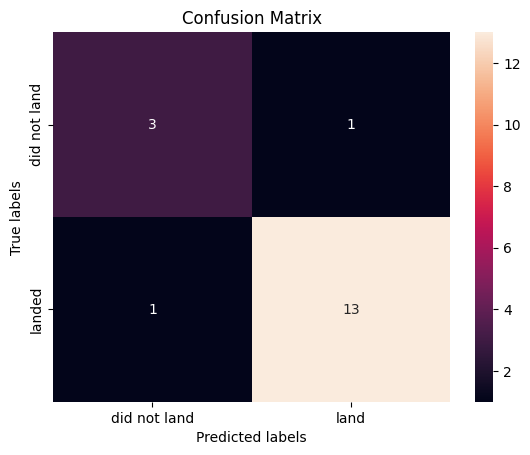

In [26]:
# Predictions 
y_pred_tree = tree_cv.predict(X_test)

# Create a confusion matrix
plot_confusion_matrix(y_test, y_pred_tree)

## 6-10) K nearest neighboors (kNN) : Fitting the model

We're going to create decision tree classifier object, then ceate a `GridSearcgCV` object `knn_cv` with cv=10, and fit the object to find the best parameters from the dictionary `cv_params_knn`.

In [27]:
%%time 


# Defining the model used
knn = KNeighborsClassifier()


# Defining the dictionary of hyperparameters to tune
cv_params_knn = {'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
              'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
              'p': [1,2]}


# Scoring dictionary
scoring = {"accuracy", "precision", "recall", "f1"}


# Defining the grid search object
knn_cv = GridSearchCV(estimator=knn,
                       param_grid= cv_params_knn,
                       scoring=scoring,
                       cv = 10,
                       refit= "accuracy")

# Execute search
knn_cv.fit(X_train, y_train)

CPU times: total: 8.69 s
Wall time: 7.74 s


GridSearchCV(cv=10, estimator=KNeighborsClassifier(),
             param_grid={'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
                         'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                         'p': [1, 2]},
             refit='accuracy',
             scoring={'f1', 'accuracy', 'precision', 'recall'})

In [28]:
print("Tuned hyperparameters : (best parameters) :\n", knn_cv.best_params_)
print("The accuracy associated with the best set of hyperparameters : ", knn_cv.best_score_)

Tuned hyperparameters : (best parameters) :
 {'algorithm': 'auto', 'n_neighbors': 8, 'p': 1}
The accuracy associated with the best set of hyperparameters :  0.85


## 6-11) kNN :  Evaluating the model

Let's evaluate the model by calculating the accuracy on the test data using the `score` method.

In [29]:
print('Accuracy on test data is: {:.3f}'.format(knn_cv.score(X_test, y_test)))

Accuracy on test data is: 0.833


## 6-12) kNN :  Confusion Matrix

Let's look at the confusion matrix

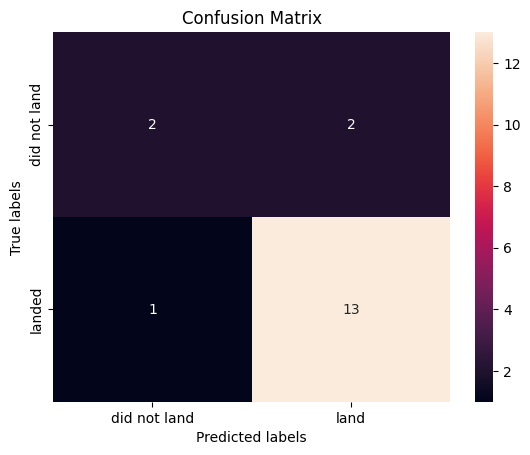

In [30]:
# Predictions 
y_pred_knn = knn_cv.predict(X_test)

# Create a confusion matrix
plot_confusion_matrix(y_test, y_pred_knn)

# The algorithm that preformes the best

In [41]:
Report = pd.DataFrame({'Method' : ['Test Data Accuracy']})

knn_accuracy=knn_cv.score(X_test, y_test)
Decision_tree_accuracy=tree_cv.score(X_test, y_test)
SVM_accuracy=svm_cv.score(X_test, y_test)
Logistic_Regression=lr_cv.score(X_test, y_test)

Report['Logistic_Reg'] = [Logistic_Regression]
Report['SVM'] = [SVM_accuracy]
Report['Decision Tree'] = [Decision_tree_accuracy]
Report['KNN'] = [knn_accuracy]

Report = Report.transpose()
Report.columns = Report.iloc[0]
Report = Report[1:]

Report


Method,Test Data Accuracy
Logistic_Reg,0.833333
SVM,0.888889
Decision Tree,0.888889
KNN,0.833333


<a href="https://www.linkedin.com/in/dahami/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDS0321ENSkillsNetwork26802033-2021-01-01">

<a href="https://www.linkedin.com/in/joseph-s-50398b136/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDS0321ENSkillsNetwork26802033-2021-01-01">

[Younes Dahami](https://www.linkedin.com/in/dahami/)

# Change Log

| Date (YYYY-MM-DD) | Version | Changed By      | Change Description      |
| ----------------- | ------- | -------------   | ----------------------- |
| 2024-04-16       | 1.0     | Younes Dahami   |  initial version |


Copyright © 2020 IBM Corporation. All rights reserved.